In [1]:
import numpy as np
import pandas as pd
import glob
import os

In [2]:
# pd.set_option('display.max_rows', None)

# input_root_path = "../data"
input_root_path = "../input/travel-time"
# output_root_path = "../data"
output_root_path = "../working"


# Pre-processing

In [3]:
DELAY_THRESH = 20

In [4]:
def load_csv_to_df(files, filename=None):
    df = pd.concat((pd.read_csv(f, skipinitialspace = True) for f in files), ignore_index=True)
    if filename:
        df.to_csv(os.path.join(output_root_path, filename))
    return df

In [5]:
# Load data 

tasks_joined_files = glob.glob(os.path.join(input_root_path, "Update Travel Time Archive/Travel Time Task/TravelTimeTaskArchive*.csv"))
df_tasks = load_csv_to_df(tasks_joined_files)
# df_tasks = load_csv_to_df(tasks_joined_files, filename="all_TravelTimeTaskArchive.csv")

summary_joined_files = glob.glob(os.path.join(input_root_path, "Update Travel Time Archive/Travel Time Summary/TravelTimeSummaryTaskArchive*.csv"))
df_summary = load_csv_to_df(summary_joined_files)

df_tasks

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength
0,75946582969,Spread 4B - NB,7/8/2021 8:54:49 PM,0.0,0.0,0.0,OK,70.71
1,75946582969,Spread 4B - NB,7/8/2021 8:54:49 PM,0.0,0.0,0.0,OK,70.71
2,75946582969,Spread 4B - NB,7/8/2021 8:54:49 PM,0.0,0.0,0.0,OK,70.71
3,75946582969,Spread 4B - NB,7/8/2021 8:54:49 PM,0.0,0.0,0.0,OK,70.71
4,75946582969,Spread 4B - NB,7/8/2021 8:54:49 PM,0.0,0.0,0.0,OK,70.71
...,...,...,...,...,...,...,...,...
13438804,49923813616,MRPP-AP 11 • SB • Ledcor Sicim LP,7/9/2021 12:16:57 AM,0.0,0.0,0.0,OK,3.06
13438805,49923813616,MRPP-AP 11 • SB • Ledcor Sicim LP,7/9/2021 12:16:57 AM,0.0,0.0,0.0,OK,3.06
13438806,49923813616,MRPP-AP 11 • SB • Ledcor Sicim LP,7/9/2021 12:16:57 AM,0.0,0.0,0.0,OK,3.06
13438807,49923813616,MRPP-AP 11 • SB • Ledcor Sicim LP,7/9/2021 12:16:57 AM,0.0,0.0,0.0,OK,3.06


In [6]:
def get_unique_assets(filename=None):
    df_asset = pd.concat([df_tasks[['AssetNumber', 'AssetIdentifier']], df_summary[['AssetNumber', 'AssetIdentifier']]], axis=0) 
    df_asset_unique = df_asset.drop_duplicates()
    
    if filename:
        df_asset_unique.to_csv(os.path.join(output_root_path, filename))

    return df_asset_unique

In [7]:
df_asset = get_unique_assets()
# df_asset = get_unique_assets(filename='unique_assets.csv')
df_asset

,AssetNumber,AssetIdentifier
0,75946582969,Spread 4B - NB
55,43132175891,Spread 5B - SB
193,99369489819,Spread 2 - SB
330,18357457077,Spread Burnaby to Westridge - SB
465,34592545857,Spread Reactivation Hinton to Hargraves - SB
...,...,...
6907105,53971315200,AP 4-A-11-A • SB • Ledcor Sicim LP • 623.8
6907106,23186836356,AP 4-A-Hwy 5-14 • SB • Ledcor Sicim LP • 627.1
6907107,38194039865,AP 4-A-Hwy 5-15 • SB • Ledcor Sicim LP • 627.2
6907114,50686558234,"AP-4-A-151-A, AP-4-A-151-B • SB • Ledcor Sicim..."


# Cleaning

In [8]:
# Filter out entries with zero UnderConstructionTime or BaselineTime
df_valid = df_tasks[(df_tasks['UnderConstructionTime'] != 0) & (df_tasks['BaselineTime'] != 0)].rename_axis('AllTasksIndex').reset_index()
df_valid = df_valid.rename_axis('ValidTasksIndex')
# df_valid

In [9]:
# Recalculate DelayTime & State
df_valid['CalculatedDelayTime'] = (df_valid.UnderConstructionTime - df_valid.BaselineTime).clip(lower=0).round(4)
df_valid['CalculatedState'] = np.where(df_valid['CalculatedDelayTime'] < DELAY_THRESH, 'OK', 'DELAY')
df_valid

,AllTasksIndex,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,CalculatedDelayTime,CalculatedState
ValidTasksIndex,,,,,,,,,,,
0,1000000,44853071770,Spread Reactivation Hinton to Hargraves - NB,5/23/2021 4:55:09 PM,95.90,95.37,0.53,OK,146.94,0.53,OK
1,1000001,59711435013,Spread 7 - NB,5/23/2021 4:55:09 PM,21.63,23.88,0.00,OK,33.60,0.00,OK
2,1000002,14058367507,Spread 6 - NB,5/23/2021 4:55:09 PM,40.63,41.88,0.00,OK,72.16,0.00,OK
3,1000003,50253718586,Spread 5A - SB,5/23/2021 4:55:10 PM,123.68,115.63,8.05,OK,185.13,8.05,OK
4,1000004,20828851697,Spread 5A - NB,5/23/2021 4:55:10 PM,106.97,111.38,0.00,OK,185.21,0.00,OK
...,...,...,...,...,...,...,...,...,...,...,...
3809836,12938804,88582155367,Spread 7 - SB,4/17/2021 6:00:11 PM,21.77,23.60,0.00,OK,32.98,0.00,OK
3809837,12938805,75946582969,Spread 4B - NB,4/17/2021 6:00:12 PM,43.37,45.35,0.00,OK,70.71,0.00,OK
3809838,12938806,43132175891,Spread 5B - SB,4/17/2021 6:00:12 PM,53.48,53.73,0.00,OK,87.35,0.00,OK


In [10]:
def find_delay_diff():
    diff_delay = df_valid[df_valid['DelayTime'] != df_valid['CalculatedDelayTime']]
    diff_delay.to_csv(os.path.join(output_root_path, 'wrong_DelayTime.csv'))
    return diff_delay

In [11]:
def find_state_diff():
    diff_state = df_valid[df_valid['State'] != df_valid['CalculatedState']]
    diff_state.to_csv(os.path.join(output_root_path, 'wrong_State.csv'))
    return diff_state 

# Exploratory Data Analysis

In [12]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3809841 entries, 0 to 3809840
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   AllTasksIndex          int64  
 1   AssetNumber            int64  
 2   AssetIdentifier        object 
 3   CreatedDate            object 
 4   UnderConstructionTime  float64
 5   BaselineTime           float64
 6   DelayTime              float64
 7   State                  object 
 8   SegmentLength          float64
 9   CalculatedDelayTime    float64
 10  CalculatedState        object 
dtypes: float64(5), int64(2), object(4)
memory usage: 319.7+ MB


In [13]:
df_valid.isnull().sum()

AllTasksIndex              0
AssetNumber                0
AssetIdentifier            0
CreatedDate                0
UnderConstructionTime      0
BaselineTime               0
DelayTime                  0
State                    178
SegmentLength              0
CalculatedDelayTime        0
CalculatedState            0
dtype: int64

## Plot

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
# from PIL import Image

%matplotlib inline
sns.set_style("darkgrid")
plt.style.use('ggplot')

STEP_SIZE = 0.5


In [15]:
df_valid['CreatedDate'] = pd.to_datetime(df_valid['CreatedDate'])

# Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
df_valid['CreatedDate:Weekday'] = df_valid['CreatedDate'].dt.weekday
# df_valid['CreatedDate:DayOfWeek'] = df_valid['CreatedDate'].dt.day_of_week
df_valid['CreatedDate:DayName'] = df_valid['CreatedDate'].dt.day_name()

# df_valid['CreatedDate:WeekOfYear'] = df_valid['CreatedDate'].dt.week_of_year
# df_valid['CreatedDate:DayOfYear'] = df_valid['CreatedDate'].dt.day_of_year

# df_valid['CreatedDate:Year'] = df_valid['CreatedDate'].dt.year
# df_valid['CreatedDate:Month'] = df_valid['CreatedDate'].dt.month
# # Between 1 and the number of days in the given month of the given year.
# df_valid['CreatedDate:Day'] = df_valid['CreatedDate'].dt.day
df_valid['CreatedDate:Hour'] = df_valid['CreatedDate'].dt.hour
# df_valid['CreatedDate:Minute'] = df_valid['CreatedDate'].dt.minute

         
df_valid

,AllTasksIndex,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,CalculatedDelayTime,CalculatedState,CreatedDate:Weekday,CreatedDate:DayName,CreatedDate:Hour
ValidTasksIndex,,,,,,,,,,,,,,
0,1000000,44853071770,Spread Reactivation Hinton to Hargraves - NB,2021-05-23 16:55:09,95.90,95.37,0.53,OK,146.94,0.53,OK,6,Sunday,16
1,1000001,59711435013,Spread 7 - NB,2021-05-23 16:55:09,21.63,23.88,0.00,OK,33.60,0.00,OK,6,Sunday,16
2,1000002,14058367507,Spread 6 - NB,2021-05-23 16:55:09,40.63,41.88,0.00,OK,72.16,0.00,OK,6,Sunday,16
3,1000003,50253718586,Spread 5A - SB,2021-05-23 16:55:10,123.68,115.63,8.05,OK,185.13,8.05,OK,6,Sunday,16
4,1000004,20828851697,Spread 5A - NB,2021-05-23 16:55:10,106.97,111.38,0.00,OK,185.21,0.00,OK,6,Sunday,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809836,12938804,88582155367,Spread 7 - SB,2021-04-17 18:00:11,21.77,23.60,0.00,OK,32.98,0.00,OK,5,Saturday,18
3809837,12938805,75946582969,Spread 4B - NB,2021-04-17 18:00:12,43.37,45.35,0.00,OK,70.71,0.00,OK,5,Saturday,18
3809838,12938806,43132175891,Spread 5B - SB,2021-04-17 18:00:12,53.48,53.73,0.00,OK,87.35,0.00,OK,5,Saturday,18


In [16]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3809841 entries, 0 to 3809840
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   AllTasksIndex          int64         
 1   AssetNumber            int64         
 2   AssetIdentifier        object        
 3   CreatedDate            datetime64[ns]
 4   UnderConstructionTime  float64       
 5   BaselineTime           float64       
 6   DelayTime              float64       
 7   State                  object        
 8   SegmentLength          float64       
 9   CalculatedDelayTime    float64       
 10  CalculatedState        object        
 11  CreatedDate:Weekday    int64         
 12  CreatedDate:DayName    object        
 13  CreatedDate:Hour       int64         
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 406.9+ MB


In [17]:
def draw_time_plot(loc, loc_id, time_type, plt_name):
    fig, ax = plt.subplots()
#     plt.figure(figsize=(10,10))

    # loc.plot.scatter(x='CreatedDate:DayName', y=['UnderConstructionTime', 'BaselineTime'])
    # loc.plot.scatter(x='CreatedDate:DayName', y='UnderConstructionTime')
    plt.scatter(x=loc[f'CreatedDate:{time_type}'], y=loc['UnderConstructionTime'], color='purple', marker='o', label='UnderConstructionTime (After)')
    plt.scatter(x=loc[f'CreatedDate:{time_type}'], y=loc['BaselineTime'], color='orange', marker='h', label='BaselineTime (Before)')

#     start, end = ax.get_ylim()
#     plt.yticks(np.arange(np.round(start), np.round(end)+STEP_SIZE, step=STEP_SIZE))
    if time_type == 'Hour':
        plt.xticks(np.arange(0, 24, step=1))
    
    fig.set_size_inches(14, 10)
    ax.legend()
    ax.grid(True)
    
    plt.title(f'Travel Time for AssetID {loc_id} ({time_type})')
    plt.xlabel(time_type)
    plt.ylabel('TravelTime')
    plt.tight_layout()
    plt.savefig(f'{output_root_path}/{plt_name}.png')
#     plt.show()


In [18]:
locations_id = [80002045894, 50253718586, 44853071770, 12738620179, 37528363723, 43805438913, 68881926366, 36674989230, 34592545857, 22685608926]


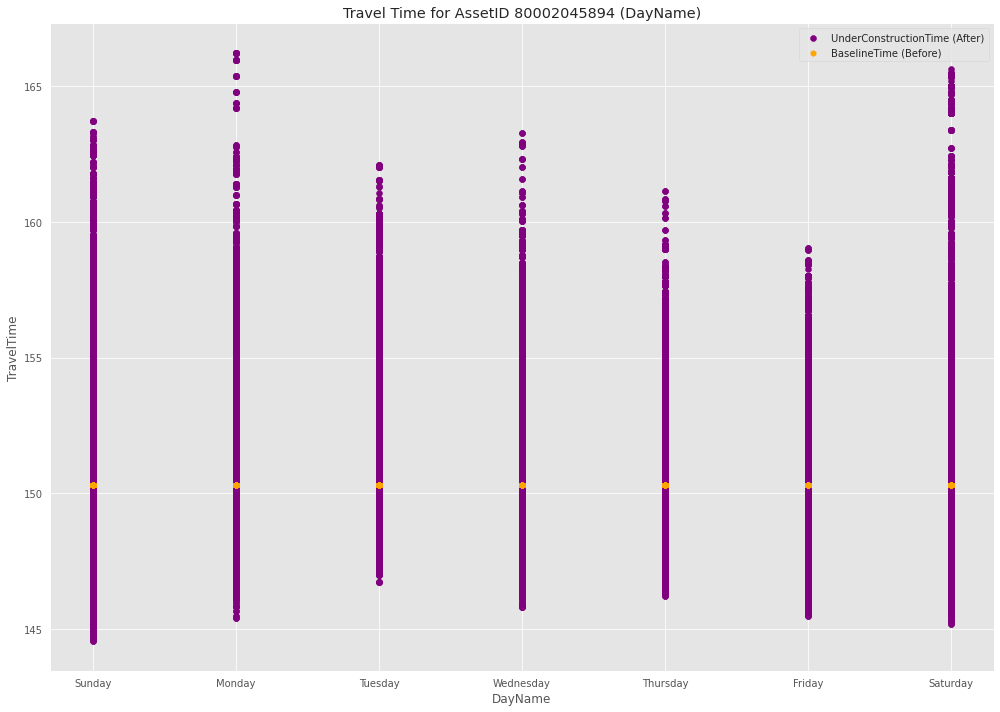

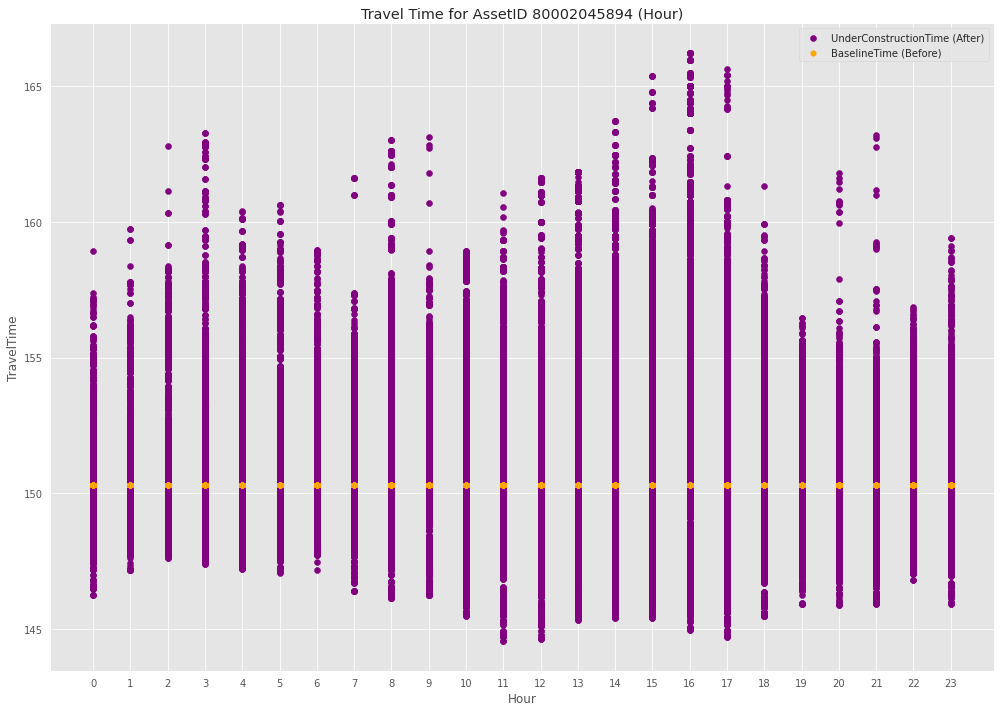

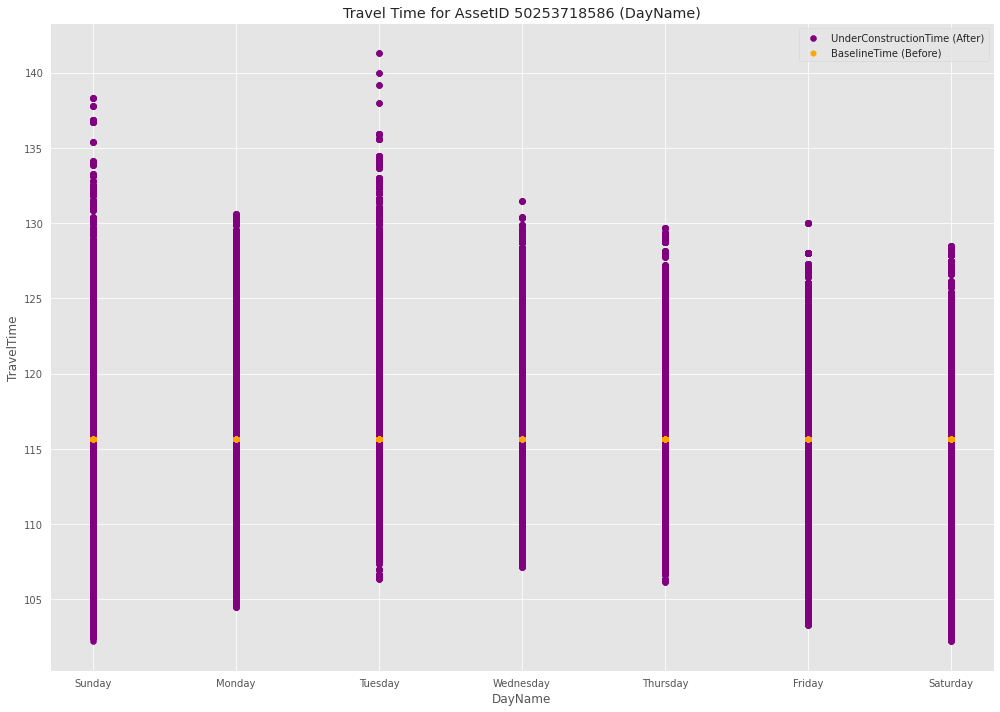

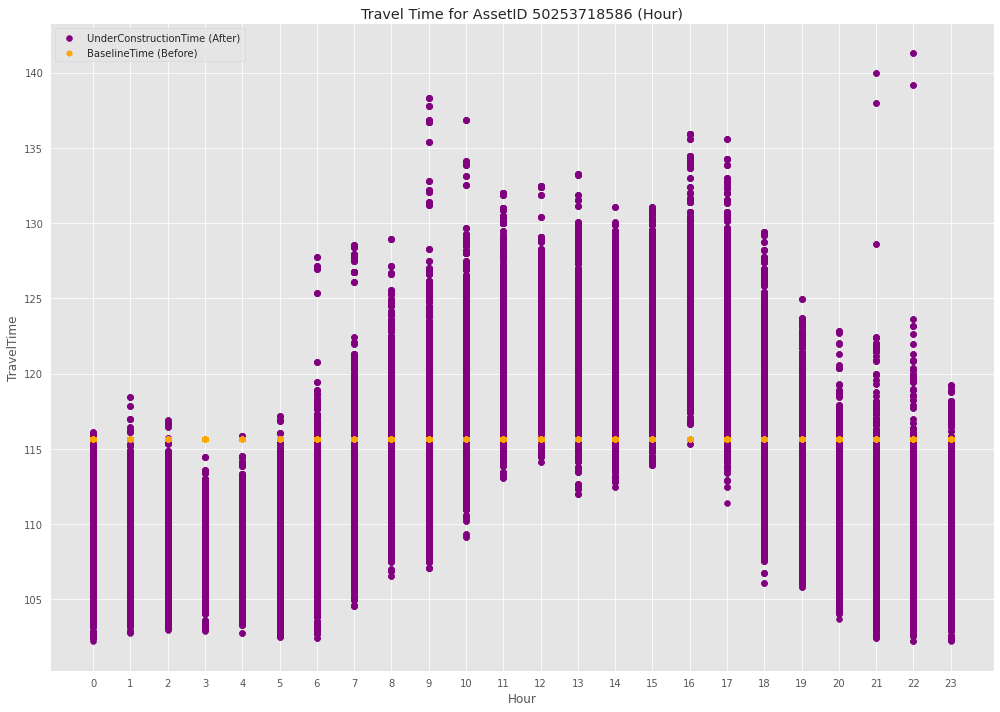

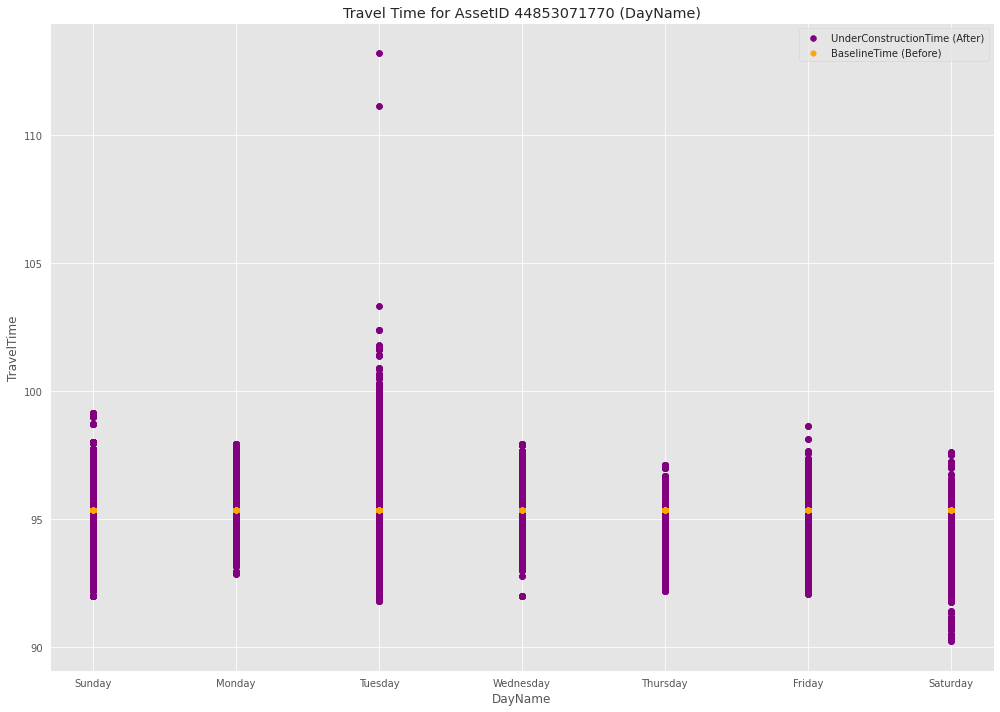

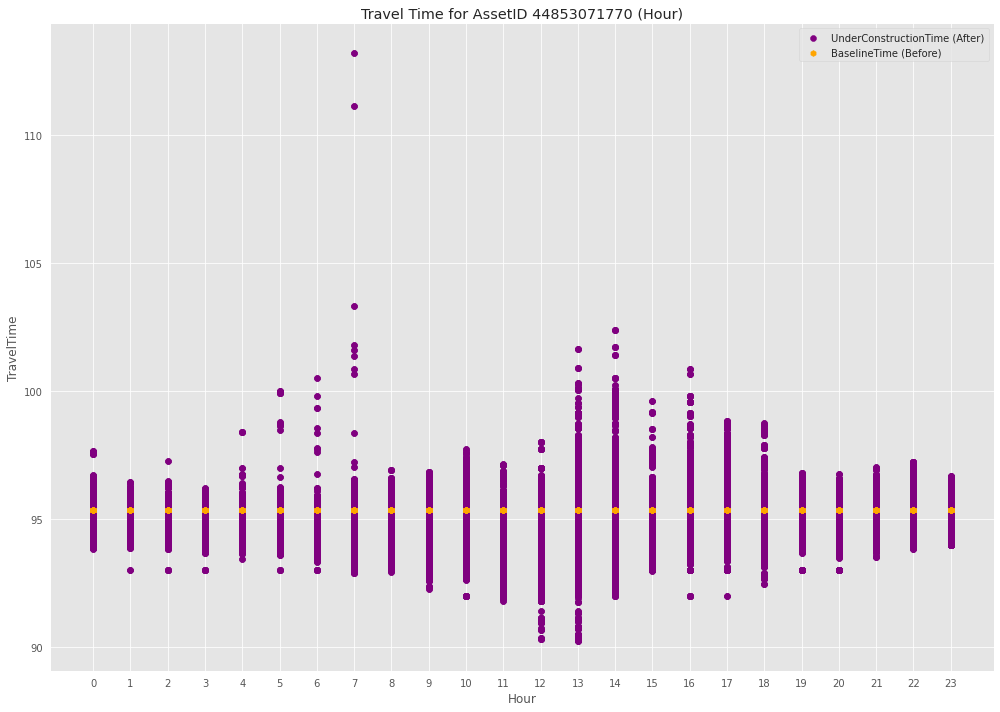

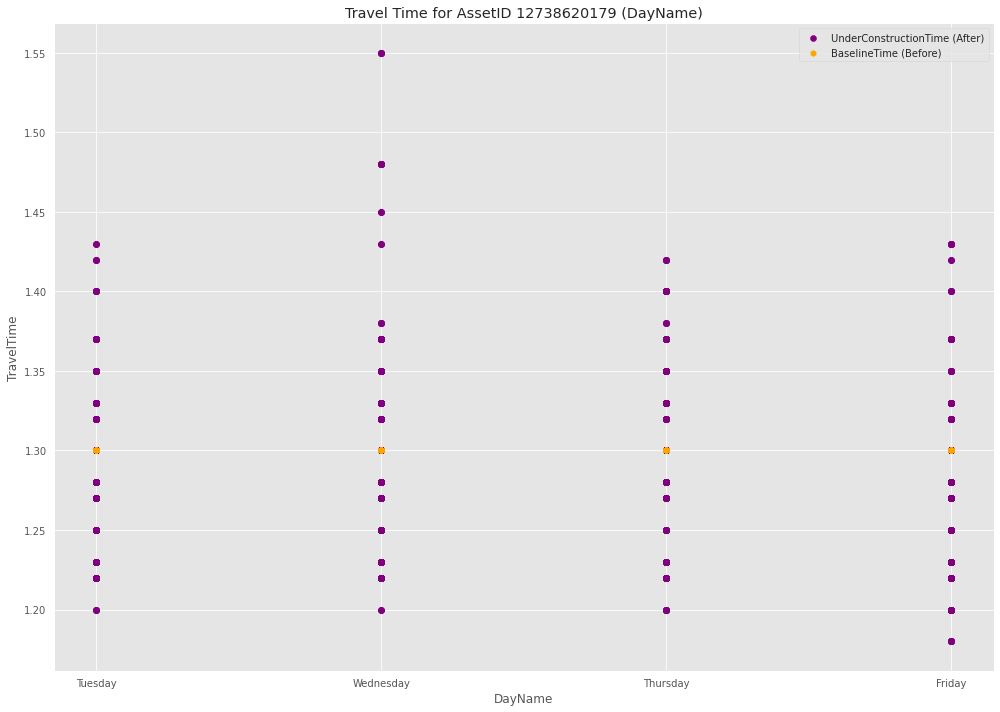

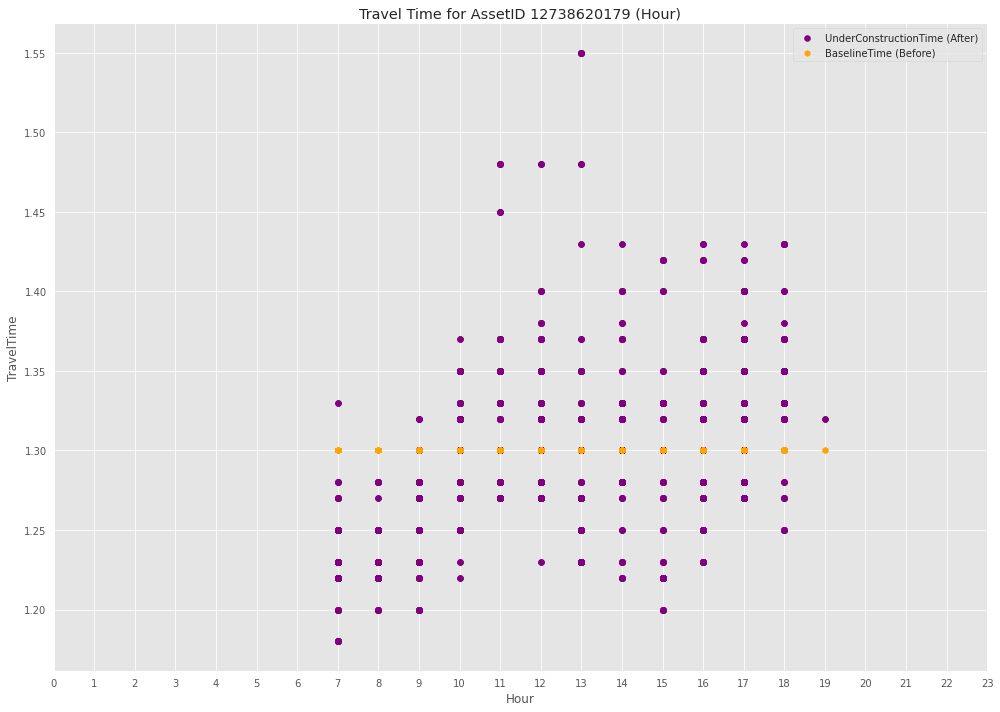

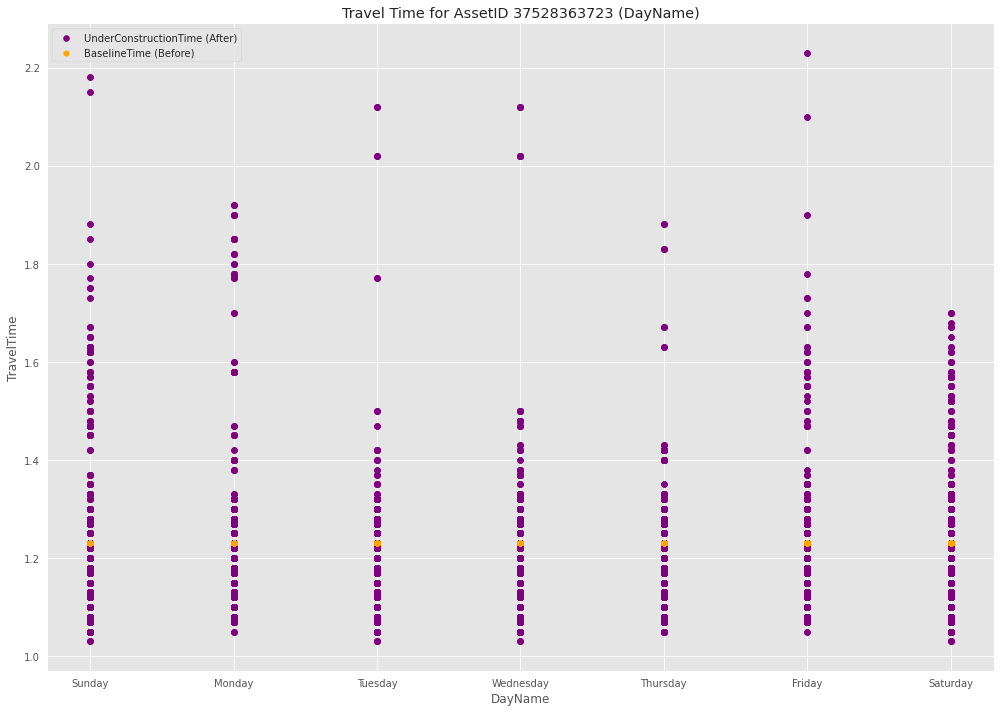

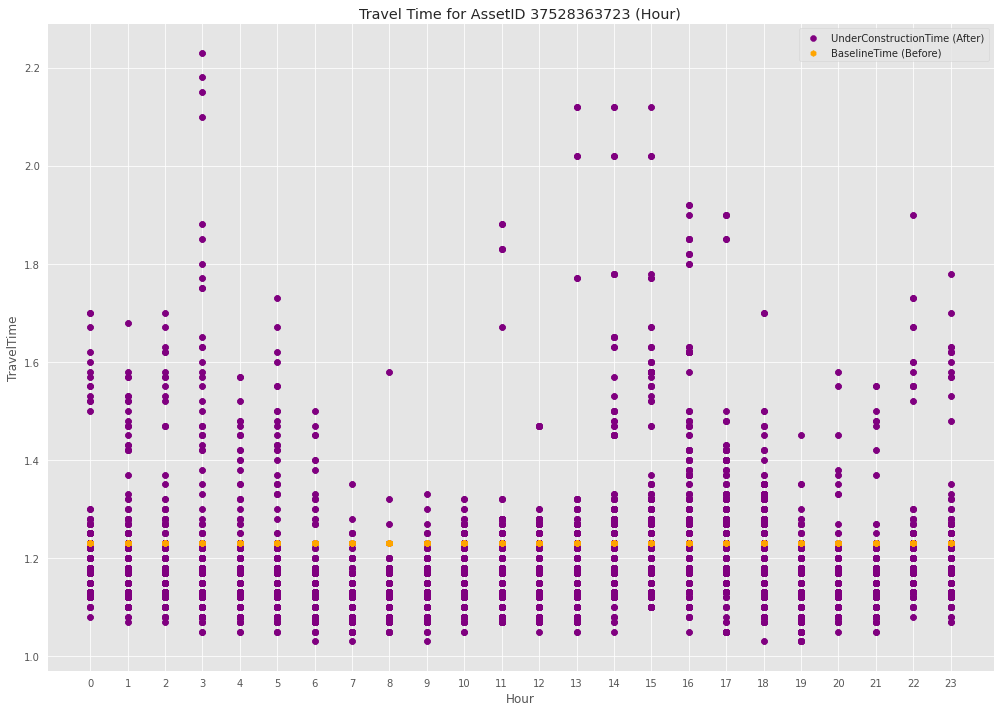

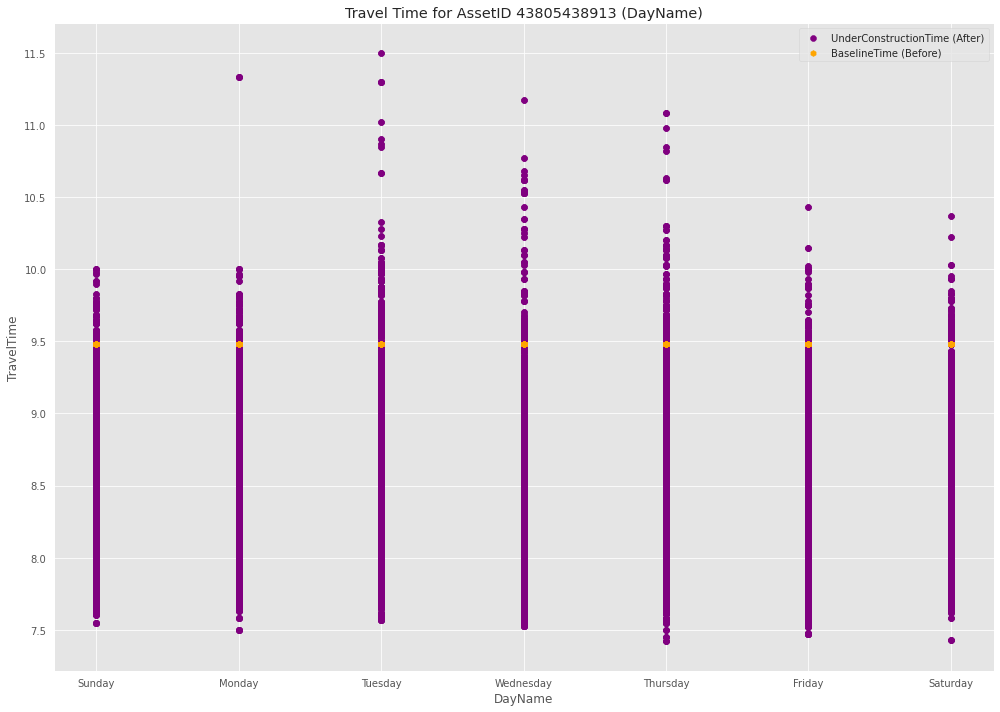

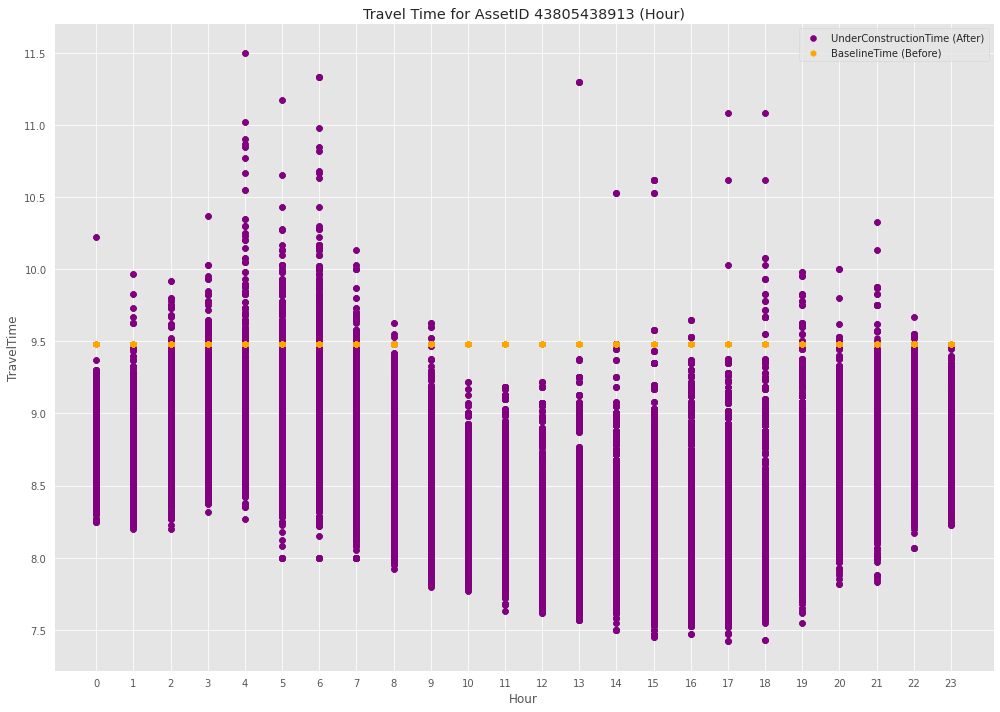

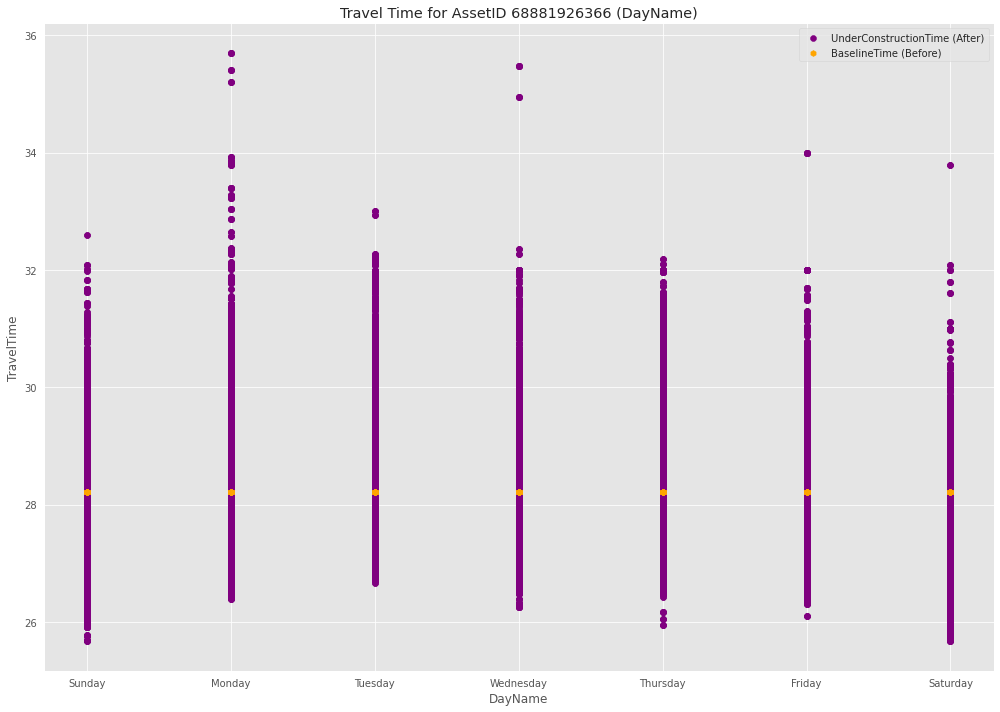

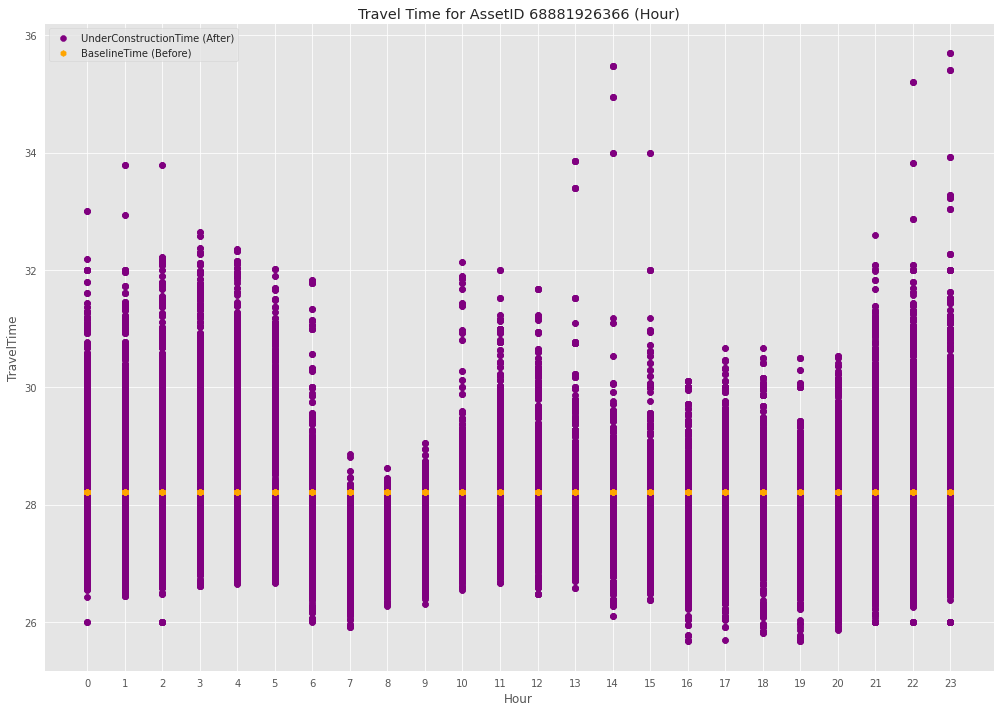

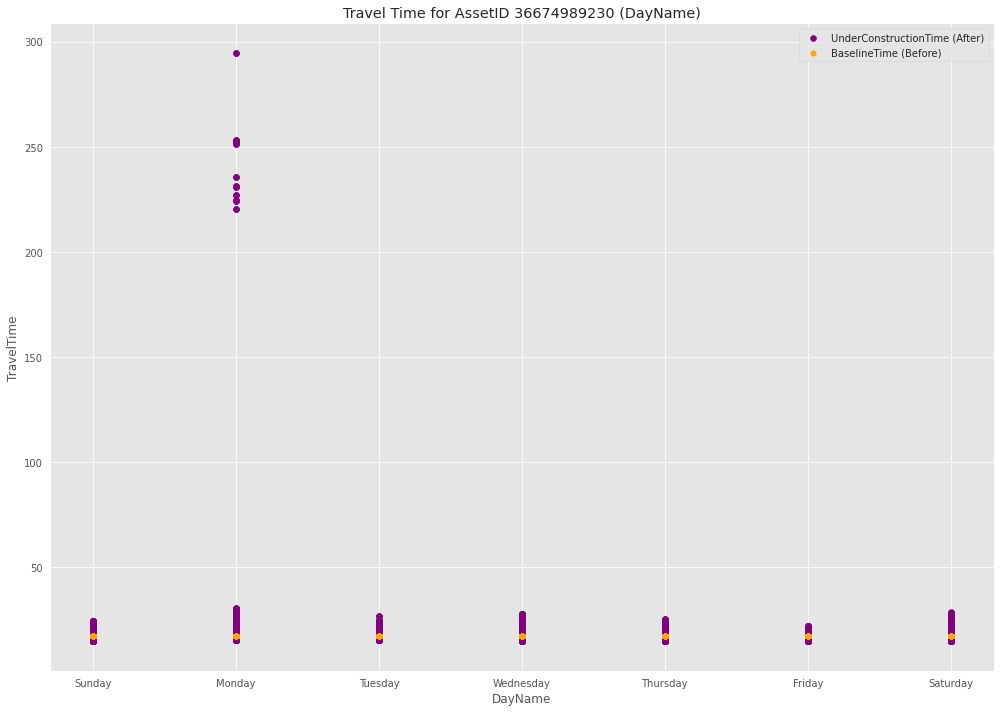

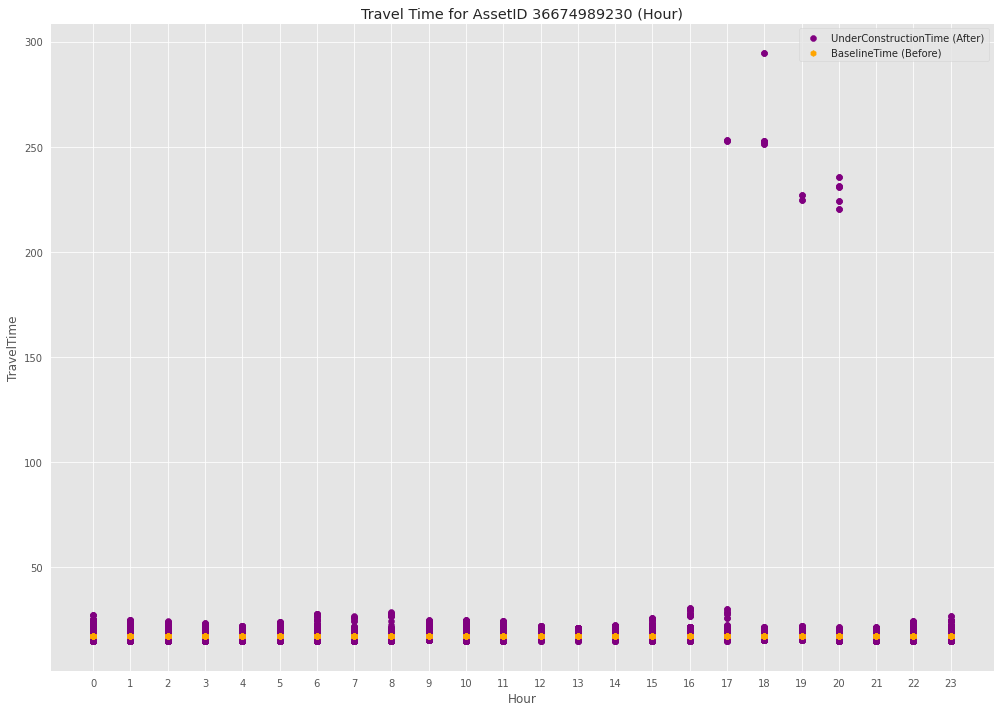

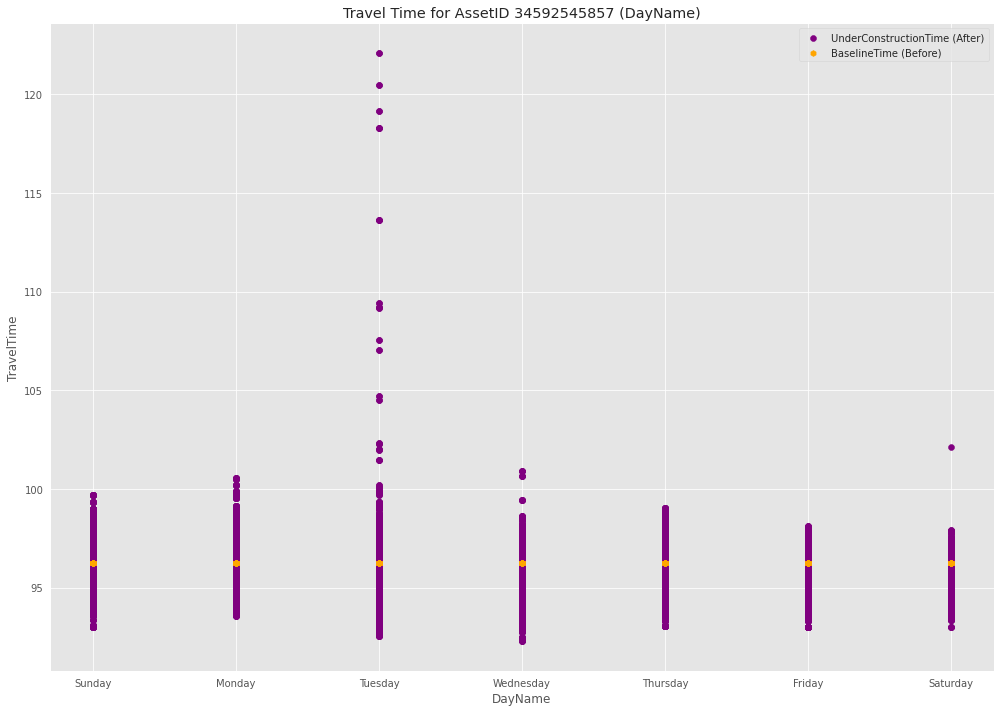

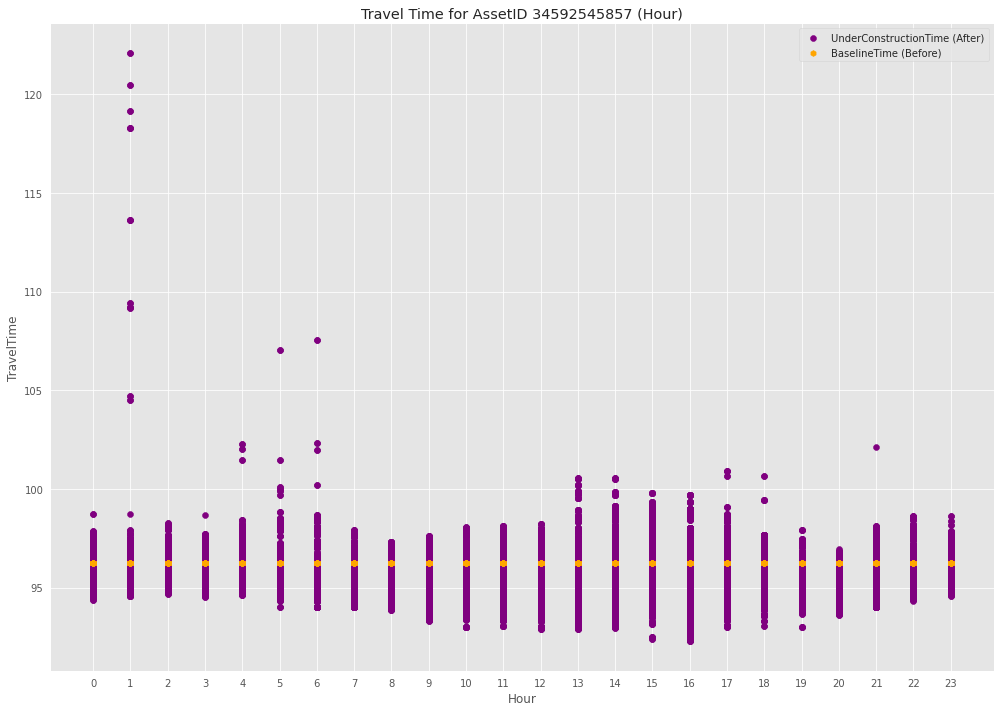

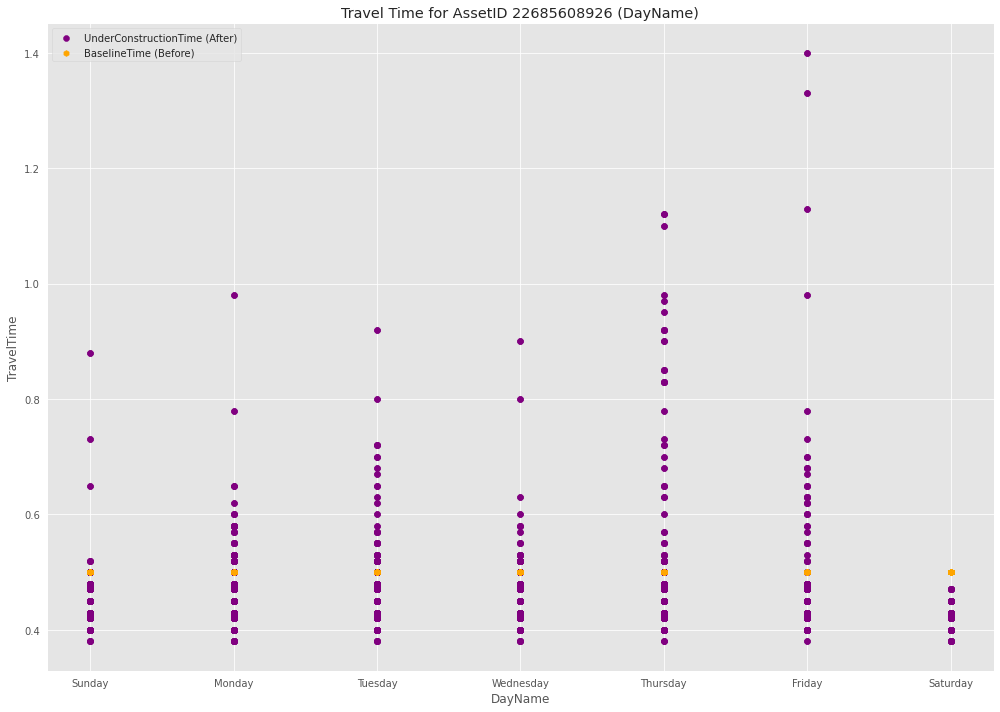

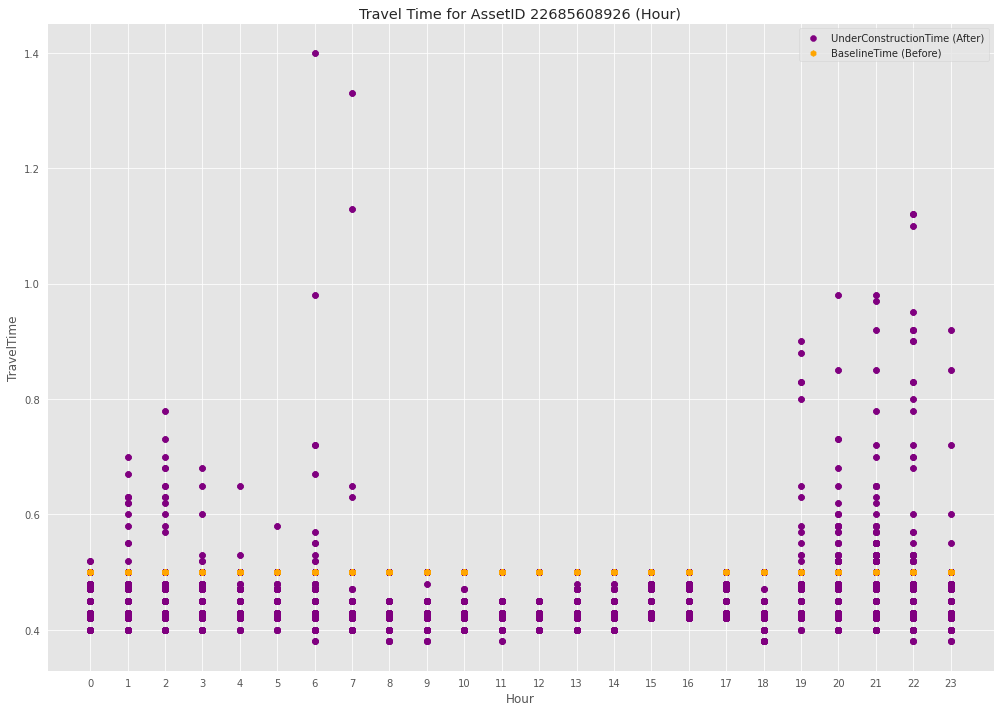

In [19]:
for location_id in locations_id:
    for time_type in ['DayName', 'Hour']:
        location = df_valid.loc[df_valid['AssetNumber'] == location_id]
        draw_time_plot(location, location_id, time_type, plt_name=f'{location_id}_{time_type}')
